# **Restricted Boltzmann Machine para eliminar ruido de Fashion MNIST**

El objetivo es implementar una RBM para eliminar ruido de imágenes del conjunto de datos Fashion MNIST. El proceso consiste en:
1. Cargar y preprocesar el conjunto de datos Fashion MNIST
2. Añadir ruido gaussiano a las imágenes limpias para crear versiones corruptas
3. Entrenar una RBM para aprender a reconstruir las imágenes originales a partir de las versiones ruidosas
4. Evaluar el rendimiento del modelo en el denoising

## Importar las librerías

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras import layers
from keras.datasets import fashion_mnist

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from tools import plot_image_comparison, plot_loss_curve, plot_noisy_clean_reconstructed

## Cargar los datos de Fashion MNIST

In [2]:
(train_images, _), (test_images, _) = fashion_mnist.load_data()

#Normalizar los valores para que estén entre 0 y 1
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

## Generar imágenes con ruido

In [3]:
#Agregar ruido gaussiano
noise_factor = 0.5
noisy_train_images = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
noisy_test_images = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

#Asegurar que los valores sigan en el rango [0,1]
noisy_train_images = np.clip(noisy_train_images, 0.0, 1.0)
noisy_test_images = np.clip(noisy_test_images, 0.0, 1.0)

#Aplanar las imágenes
train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

noisy_train_images = noisy_train_images.reshape(len(noisy_train_images), -1)
noisy_test_images = noisy_test_images.reshape(len(noisy_test_images), -1)

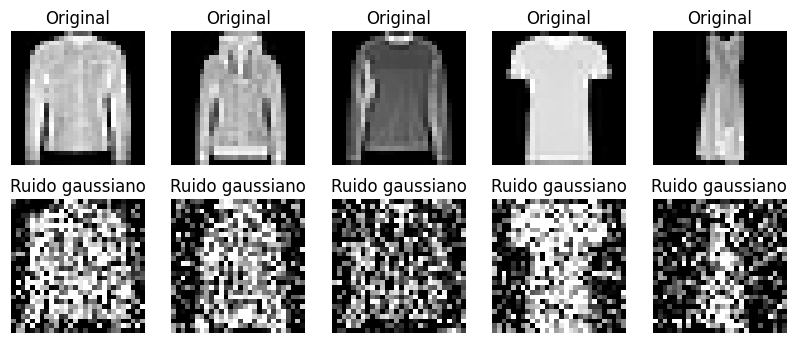

In [4]:
plot_image_comparison(images1=train_images, images2=noisy_train_images)

In [5]:
print('Shape of train images:', train_images.shape)
print('Shape of test images:', test_images.shape)
print('Shape of noisy train images:', noisy_train_images.shape)
print('Shape of noisy test images:', noisy_test_images.shape)

Shape of train images: (60000, 784)
Shape of test images: (10000, 784)
Shape of noisy train images: (60000, 784)
Shape of noisy test images: (10000, 784)


## Definir modelo RBM

In [6]:
class RBM(tf.keras.Model):
    def __init__(self, visible_dim, hidden_dim):
        super(RBM, self).__init__()
        
        self.visible_dim = visible_dim #Número de nodos visibles
        self.hidden_dim = hidden_dim #Número de nodos ocultos
        
        #Matriz de pesos que conecta la capa visible con la oculta
        self.W = self.add_weight(shape=[visible_dim, hidden_dim],
                                 initializer='random_normal',
                                 trainable=True)
        
        #Sesgos para la capa visible
        self.visible_bias = self.add_weight(shape=[visible_dim],
                                           initializer='zeros',
                                           trainable=True)
        
        #Sesgos para la capa oculta
        self.hidden_bias = self.add_weight(shape=[hidden_dim],
                                          initializer='zeros',
                                          trainable=True)

    #Paso de datos por la RBM
    def call(self, inputs):
        #Calcular las probabilidades de activación de la capa oculta
        hidden_prob = tf.nn.sigmoid(tf.matmul(inputs, self.W) + self.hidden_bias)
        
        #Muestreo de los estados ocultos (binarios)
        hidden_states = tf.nn.sigmoid(hidden_prob - tf.random.uniform(tf.shape(hidden_prob)))
        
        #Calcular las probabilidades de la capa visible
        visible_prob = tf.nn.sigmoid(tf.matmul(hidden_states, tf.transpose(self.W)) + self.visible_bias)
        
        return visible_prob
    

visible_dim = 784 #28x28 píxeles de la imagen
hidden_dim = int(visible_dim / 2)

#Crear el modelo RBM
rbm = RBM(visible_dim, hidden_dim)
rbm.compile(optimizer='adam', loss='mean_squared_error')

## Entrenar modelo

In [7]:
history = rbm.fit(noisy_train_images, train_images, epochs=50, validation_split=0.01)

Epoch 1/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0638 - val_loss: 0.0354
Epoch 2/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0323 - val_loss: 0.0283
Epoch 3/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0272 - val_loss: 0.0255
Epoch 4/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0248 - val_loss: 0.0240
Epoch 5/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 6/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0223 - val_loss: 0.0224
Epoch 7/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0217 - val_loss: 0.0217
Epoch 8/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0211 - val_loss: 0.0211
Epoch 9/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0207 - val_loss: 0.0210
Epoch 10/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0204 - val_loss: 0.0206
Epoch 11/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0201 - val_loss: 0.0203
Epoch 12

## Pérdida en el entrenamiento

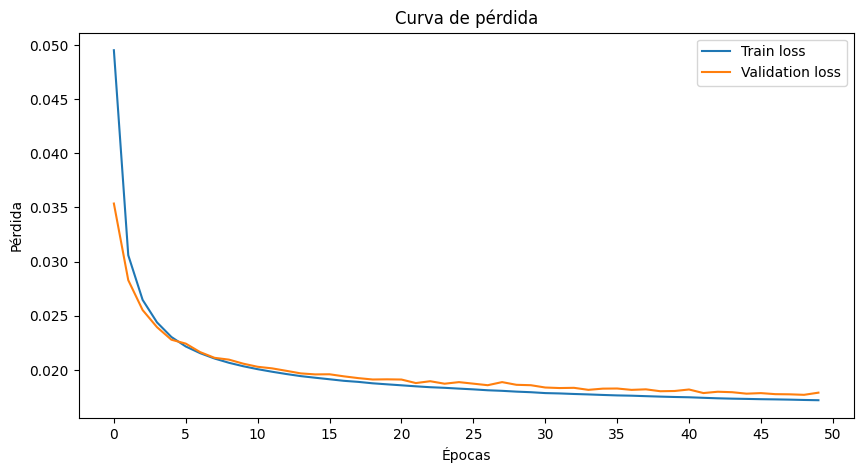

In [8]:
plot_loss_curve(history, epochs=50)

## Imágenes ruidosas, limpias y reconstruidas en el conjunto de entrenamiento

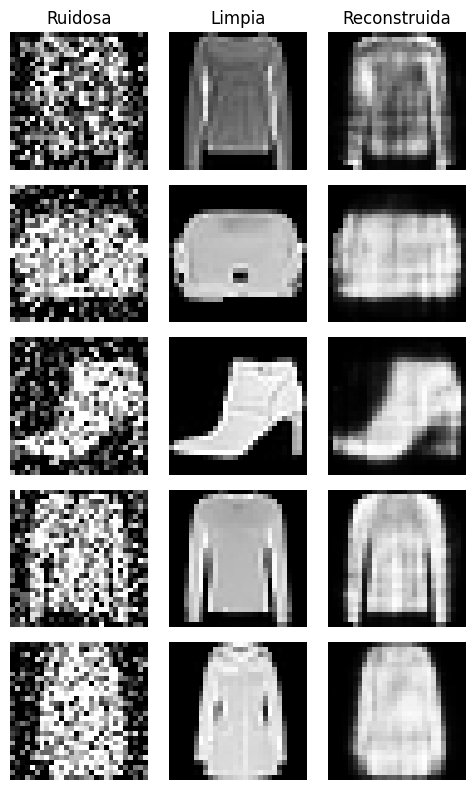

In [9]:
plot_noisy_clean_reconstructed(noisy_train_images, train_images, rbm, num_images=5, save_path='comparación_train.png')

## Imágenes ruidosas, limpias y reconstruidas en el conjunto de prueba

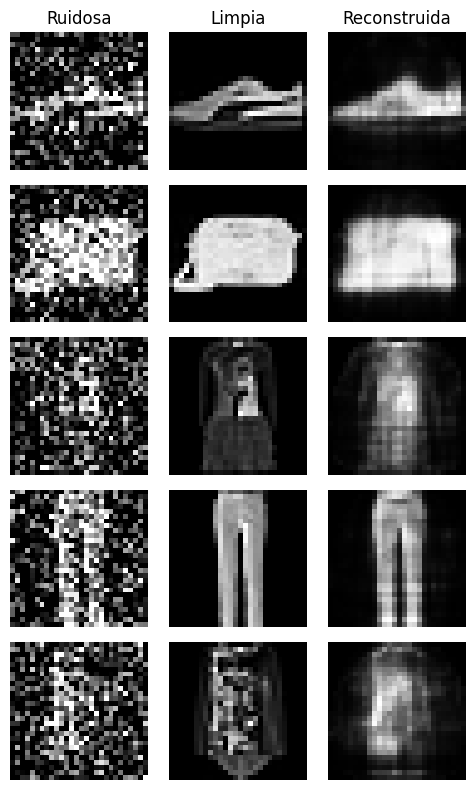

In [10]:
plot_noisy_clean_reconstructed(noisy_test_images, test_images, rbm, num_images=5, save_path='comparación_test.png')

## Evaluar el modelo utilizando el conjunto de prueba

In [11]:
reconstructed = rbm.predict(noisy_test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [12]:
mse = rbm.evaluate(noisy_test_images, test_images)

psnr_value = psnr(test_images, reconstructed, data_range=1)

ssim_values = []
for i in range(len(test_images)):
    original_2d = test_images[i].reshape(28, 28) #Convertir de 1D (784) a 2D (28x28)
    reconstructed_2d = reconstructed[i].reshape(28, 28)
    ssim_value = ssim(original_2d, reconstructed_2d, data_range=1)
    ssim_values.append(ssim_value)
ssim_avg = np.mean(ssim_values)

print(f'MSE: {mse}')
print(f'PSNR: {psnr_value} dB')
print(f'SSIM promedio: {ssim_avg}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0179
MSE: 0.017982451245188713
PSNR: 17.456686640454883 dB
SSIM promedio: 0.5840951578920738
